# U - Net
## Problem: 

Seismic data is collected using reflection seismology, or seismic reflection. The method requires a controlled seismic source of energy, such as compressed air or a seismic vibrator, and sensors record the reflection from rock interfaces within the subsurface. The recorded data is then processed to create a 3D view of earth’s interior. Reflection seismology is similar to X-ray, sonar and echolocation.

A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. In theory, the strength of reflection is directly proportional to the difference in the physical properties on either sides of the interface. While seismic images show rock boundaries, they don't say much about the rock themselves; some rocks are easy to identify while some are difficult.

There are several areas of the world where there are vast quantities of salt in the subsurface. One of the challenges of seismic imaging is to identify the part of subsurface which is salt. Salt has characteristics that makes it both simple and hard to identify. Salt density is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of salt is 4.5 km/sec, which is usually faster than its surrounding rocks. This difference creates a sharp reflection at the salt-sediment interface. Usually salt is an amorphous rock without much internal structure. This means that there is typically not much reflectivity inside the salt, unless there are sediments trapped inside it. The unusually high seismic velocity of salt can create problems with seismic imaging.

### Data
The data is a set of images chosen at various locations chosen at random in the subsurface. The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. In addition to the seismic images, the depth of the imaged location is provided for each image. The goal of the competition is to segment regions that contain salt.

#### Source: 
https://www.kaggle.com/c/tgs-salt-identification-challenge


### Note: 
Accept the terms and download data from the above link

### Aim: 

Implement U-Net neural model architecture in keras to solve this problem.


In this, you are asked to segment salt deposits beneath the Earth’s surface. Given a set of seismic images that are 101 x 101 pixels each and each pixel we need to classify as either salt or sediment. Our goal is to segment regions that contain salt. A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. 

### Broad Steps:

1. Download the dataset
2. Upload to Drive
3. Import from drive to colab
4. Load the images and create training data.
5. Build U-net Model
6. Train your model.
7. Check the validation accuracy and plot sample.

In [0]:
#Importing necessary libraries
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [0]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### 1.Set your project path where you have your data and related files for this lab.

In [0]:
project_path ='/content/drive/My Drive/Res 9/External/'

In [0]:
ls

drive/  sample_data/


In [0]:
os.chdir('/content/drive/My Drive/Res 9/External/')

In [0]:
pwd

'/content/drive/My Drive/Res 9/External'

### 2. Set the necessary parameters

## Setup

In [0]:
im_width = 128      #width of your train image
im_height = 128     #hight of your train image
#border =        
path_train = project_path + 'train/'   #Path for your train data

# 3. Make directory for train data at in your project/lab folder.

Hint - use !mkdir function.

In [0]:
!mkdir -p traindata

In [0]:
pwd

'/content/drive/My Drive/Res 9/External'

In [0]:
ls

data-20190421T070619Z-001.zip  traindata/  train.zip


# 4. Extract your train images to the train directory you have just created above. 
train.zip and test.zip files available at your google drive/local system.

As a good practice - Upload or copy the data at your project path folder.

Make sure you are providing the right project_path.

In [0]:
#For simplicity we have added the required code here.
from zipfile import ZipFile

with ZipFile(project_path + 'train.zip', 'r') as zf:
  zf.extractall('traindata/')


In [0]:
#The train file have both images and masks with the same names_ids.

In [0]:
ls traindata


images/  masks/


### 5. Get the list of names of images and masks and name the list imagelist and masklist.

Hint - Use os.listdir() funtions.

In [0]:
pwd

'/content'

In [0]:
os.chdir('/content/drive/My Drive/Res 9/External/traindata/')

In [0]:
pwd

'/content/drive/My Drive/Res 9/External/traindata'

In [0]:
os.listdir()

['images', 'masks']

In [0]:
os.chdir('/content/drive/My Drive/Res 9/External/traindata/images/')

In [0]:
imagelist = os.listdir()

In [0]:
imagelist[-1]

'9ae45b19d3.png'

In [0]:
masklist = os.listdir()

In [0]:
os.chdir('/content/drive/My Drive/Res 9/External/traindata/masks/')

In [0]:
pwd

'/content/drive/My Drive/Res 9/External/traindata/masks'

In [0]:
masklist[-1]

'9ae45b19d3.png'

In [0]:
#Test your list names by printing some of the names as given below.
print(imagelist[-1])
print(masklist[-1])
print(imagelist[10])
print(masklist[10])

9ae45b19d3.png
9ae45b19d3.png
e8757626a1.png
e8757626a1.png


# 6. Read and test your images and respective masks.

Hint -

import  matplotlib.pyplot as plt

import cv2

plt.imshow(cv2.imread('path of image'))

plt.imshow(cv2.imread('path of mask'))


In [0]:
import matplotlib.pyplot as plt

import cv2


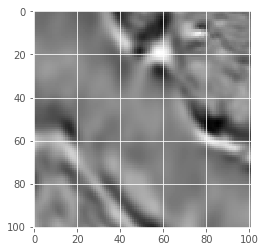

In [0]:

plt.imshow(cv2.imread('/content/drive/My Drive/Res 9/External/traindata/images/0a1742c740.png').squeeze())


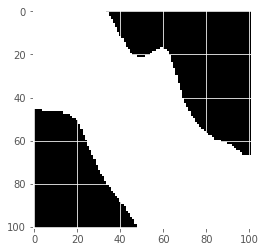

In [0]:

plt.imshow(cv2.imread('/content/drive/My Drive/Res 9/External/traindata/masks/0a1742c740.png').squeeze())

# 7. Create your training data.

Hints - 

image_path = os.path.join(project_path +'path of your image directory' +n )

mask_path = os.path.join(project_path +'path of your mask directory'+n )

In [0]:
len(imagelist)

4000

In [0]:
len(masklist)

4000

In [0]:
k = imagelist.index('8d08955cdf.png')
k

3000

In [0]:
 for n in imagelist: 
        k = imagelist.index(n)
        print(n)

d80ead8703.png
b012e9ebb0.png
d3034e7a60.png
ae2ef70d51.png
1af44a9db0.png
41cfd4b320.png
853e89d0d3.png
2a484baa26.png
92e617896e.png
b70f0ab0c2.png
e8757626a1.png
6a3d92ce59.png
127ef4105f.png
d21012f5c1.png
1cb9549d2c.png
e030bdae65.png
0cf7155eb6.png
badb3ea766.png
9bd58061d6.png
2b1e71c2a3.png
28d42de29f.png
10833853b3.png
ef13247eed.png
bce104494c.png
c8ce151a18.png
302ea1ac81.png
59b1bac5d5.png
a3e0a0c779.png
be565e046b.png
e39ded223d.png
9eaf536a63.png
568d119e66.png
5448c46aac.png
452b06b003.png
a8ef242dfd.png
cdf9422054.png
5bb48ef0ea.png
bfbb9b9149.png
fc87224914.png
157b2aa3e0.png
cb2c20898a.png
d71e91efc0.png
ca6bdbc405.png
876e6423e6.png
851a37ac37.png
85fe62d2d6.png
0497f2d447.png
10aa115164.png
d6471dc0a3.png
9722dedee7.png
18f3626b0f.png
2388b3eb40.png
3525fcea1e.png
b6c52b4a53.png
04234be388.png
68d00224e0.png
e0cfbbcb0c.png
7738fbabca.png
51179a1815.png
a32a4a2256.png
269b6cad0d.png
4e961dd0ed.png
cf7abfc8bb.png
5e98f349f3.png
2fbde8630d.png
a3605816c1.png
9d354bc9e7

In [0]:
 X = np.zeros(((len(imagelist), im_height, im_width, 1)), dtype=np.float32)

In [0]:
X[0].shape


(128, 128, 1)

In [0]:
 y = np.zeros(((len(masklist), im_height, im_width, 1)), dtype=np.float32)

In [0]:
y[0].shape

(128, 128, 1)

In [0]:
for n in imagelist: 
        k = imagelist.index(n)
        image_path =  os.path.join(project_path +'traindata/images/' +n )
        resized_img = Image.open(image_path)
        resized_img = resized_img.resize((im_width, im_height))
        resized_img = np.reshape(resized_img.convert('L'), (128,128,1))
        X[k] = resized_img
        print(resized_img)

In [0]:
from PIL import Image

In [0]:
# Get and resize train images and masks
def get_data():
    X = np.zeros(((len(imagelist), im_height, im_width, 1)), dtype=np.float32) # Create an array for image
    y = np.zeros(((len(masklist), im_height, im_width,1)), dtype=np.float32) #Create an array for mask
    
    for n in imagelist: 
        k = imagelist.index(n)
        ##Add image_path
        image_path =  os.path.join(project_path +'traindata/images/' +n ) 
        
        ##Add mask_path
        # mask_path =  os.path.join(project_path +'/content/drive/My Drive/Res 9/External/traindata/masks/' +m )                                                          
        
        # Load images and resize to (128,128,1)
        resized_img = Image.open(image_path)
        resized_img = resized_img.resize((im_width, im_height))
        resized_img = np.reshape(resized_img.convert('L'), (128,128,1))
        X[k] = resized_img
        m = masklist[k]
        mask_path =  os.path.join(project_path +'traindata/masks/' +m ) 
        
        # Load masks and resize to (128,128,1)
        resized_mask = Image.open(mask_path)
        ##resized_mask = (resized_mask!=2)*1.0
        resized_mask = resized_mask.resize((128, 128))
        resized_mask = np.reshape(resized_mask.convert('L'), (128,128,1))
        ##resized_mask = 1.0*(resized_mask[:,:,0]>0.2)
        y[k] = resized_mask
        
        # Save images
        X[k, ..., 0] = resized_img.squeeze() / 255
        y[k] = resized_mask/255
    print('Done!')
    
    ##if train:
    return X, y
    ##else:
        ##return X
    
X, y = get_data()

Done!


In [0]:
X.shape

(4000, 128, 128, 1)

In [0]:
y.shape

(4000, 128, 128, 1)

In [0]:
y[5]

array([[[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32)

In [0]:
# Split train and valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)

In [0]:
y_train[5]

array([[[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]], dtype=float32)

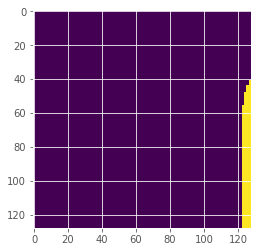

In [0]:
plt.imshow(y_train[35].squeeze())

In [0]:
X_train.shape

(3400, 128, 128, 1)

In [0]:
y_train.shape

(3400, 128, 128, 1)

In [0]:
X_valid.shape

(600, 128, 128, 1)

In [0]:
y_valid.shape

(600, 128, 128, 1)

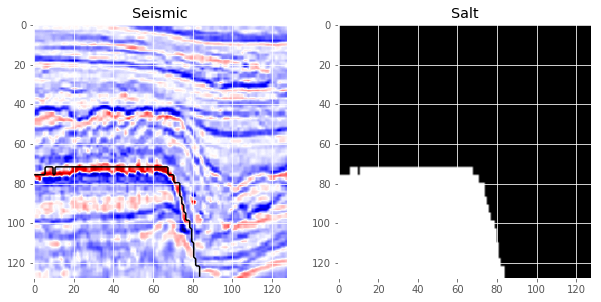

In [0]:
## Test your data whether it looks fine - Random check
import random 
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');




### 8. Define loss and dice_coeff function.

In [0]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [0]:
## This coefficient measures the similarity between sets X and Y. If the two sets are identical (i.e. they contain the same elements), the coefficient is equal to 1.0, while if X and Y have no elements in common, it is equal to 0.0. Otherwise it is somewhere in between.

### 9. Build and compile UNet Model for your data.

Hint - 
You can install and use segmentation models from this github repository.

#Install segmentation models

!pip install git+https://github.com/qubvel/segmentation_models

In [0]:
! pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-lkq1_1j5
  Stored in directory: /tmp/pip-ephem-wheel-cache-fqy5e9m5/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [0]:
#Import libraries
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from keras.layers import Input, Conv2D, Reshape
from keras.models import Model

/usr/local/lib/python3.6/dist-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [0]:
X_train.shape[-1]

1

In [0]:
  x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)

In [0]:
## model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(None, None, 1))
#compile your model by adding the parameters like optimizer, loss and metrics.

base_model = Unet(backbone_name='resnet34', encoder_weights='imagenet')
inp = Input(shape=(128, 128, 1))
l1 = Conv2D(3, (1, 1))(inp)
out = base_model(l1)

## 1st Convoulution Layer
x=Conv2D(filters = 16, kernel_size = (3, 3),activation="relu",kernel_initializer = 'he_normal', padding = 'same')(out)
x=BatchNormalization()(x)

## 2nd Convoulution Layer
x=Conv2D(filters = 16, kernel_size = (3, 3),activation="relu",kernel_initializer = 'he_normal', padding = 'same')(out)
x=BatchNormalization()(x)
outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)


model = Model(inp,outputs=outputs, name=base_model.name)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
## model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(None, None, 1))

In [0]:
import tensorflow as tf
from keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
# compile model
model.compile(optimizer='Adam', loss=loss, metrics=[dice_coefficient])

In [0]:
#Get the summary of your model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 3)       6         
_________________________________________________________________
u-resnet34 (Model)           multiple                  24456154  
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 1)       17        
Total params: 24,456,401
Trainable params: 24,439,019
Non-trainable params: 17,382
___________________________________________________________

### 10. Fit your model using model.fit function.
Hint - As it might take long time to run. Run it for only 1 or 2 epochs.

In [0]:
model.fit(
    x=X_train,
    y=y_train,
    batch_size=50,    
    epochs=1,
    validation_data=(X_valid, y_valid)
)

Instructions for updating:
Use tf.cast instead.
Train on 3400 samples, validate on 600 samples
Epoch 1/1
3400/3400 [==============================] - 1907s 561ms/step - loss: 1.1161 - dice_coefficient: 0.5267 - val_loss: 1.2553 - val_dice_coefficient: 0.5344


In [0]:
model.evaluate(X_valid, y_valid, verbose=1)

600/600 [==============================] - 79s 131ms/step


[1.2607146724065146, 0.5335332171122233]

### 11.Predict on val set using model.predict funtion and store in preds_val variable.



In [0]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)
import numpy as np

600/600 [==============================] - 79s 131ms/step


In [0]:
#Get the threshold predictions to look at refined results.
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [0]:
#Plot a sample
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

In [0]:
## Results from training set

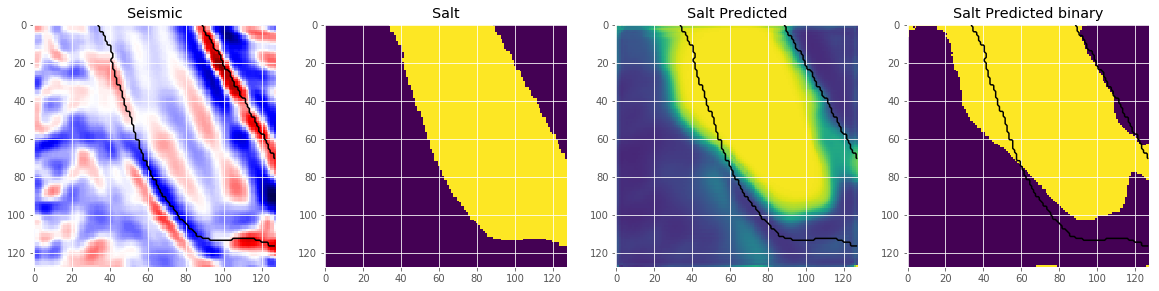

In [0]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=2)

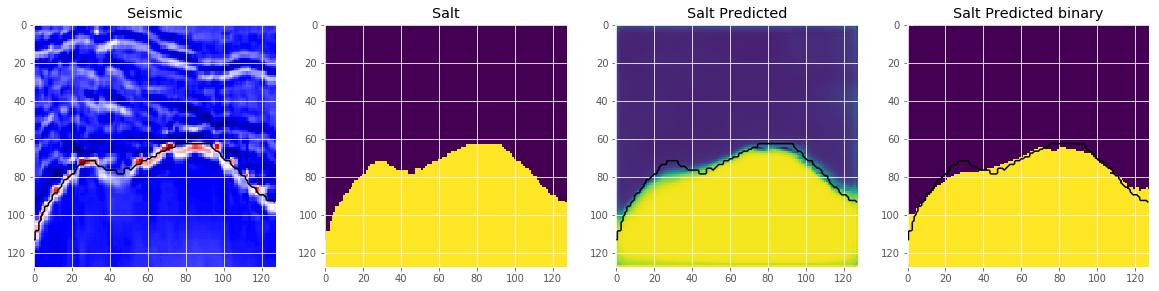

In [0]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [0]:
## Results from Validation set

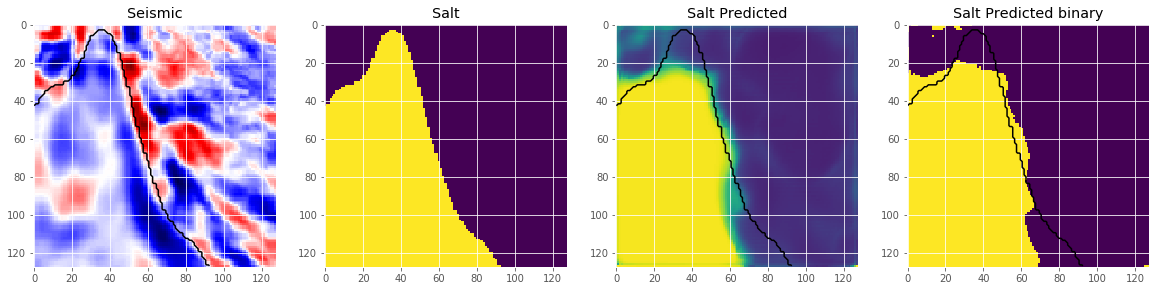

In [0]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=21)

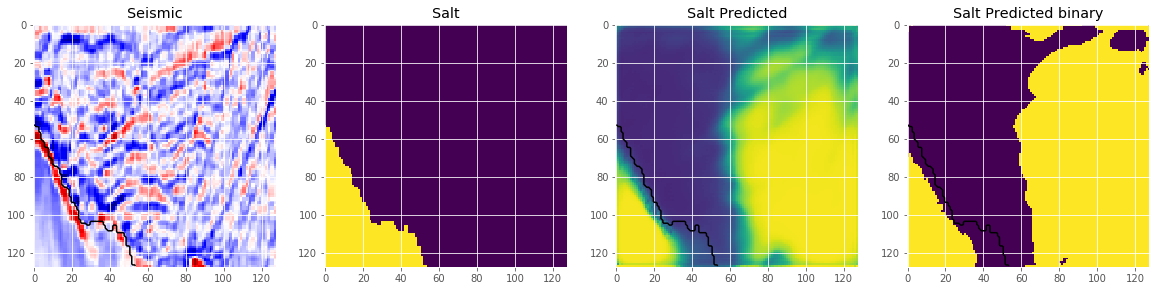

In [0]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [0]:
## Results on training set are relatively better than those on validation set which implies the model suffers from overfitting. One obvious reason could be the small number images used to train the model.

If you are getting good results- Congratulations.
If you are not, try to explore what might be the reason.

# Text generation using a RNN

Given a sequence of words from this data, train a model to predict the next word in the sequence. Longer sequences of text can be generated by calling the model repeatedly.

**Mount your Google Drive**

In [0]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
pwd

'/content'

In [0]:
os.chdir('/content/drive/My Drive/Res 9/External/')

In [0]:
pwd

'/content/drive/My Drive/Res 9/External'

### Import Keras and other libraries

In [0]:
from keras.preprocessing.text import Tokenizer
import glob

from sklearn.utils import shuffle
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam
from keras import backend

In [0]:
project_path = '/content/drive/My Drive/Res 9/External/'

In [0]:
!mkdir -p textdata

In [0]:
ls

data.zip  textdata/  traindata/  train.zip


In [0]:
#For simplicity we have added the required code here.
from zipfile import ZipFile

with ZipFile(project_path + 'data.zip', 'r') as zf:
  zf.extractall('textdata/')

In [0]:
ls textdata

data/


## Download data
Reference: Data is collected from http://www.gutenberg.org

For the lab purpose, you can load the dataset provided by Great Learning

### Load the Oscar Wilde dataset

Store all the ".txt" file names in a list

In [0]:
import glob

In [0]:
pwd

'/content/drive/My Drive/Res 9/External'

In [0]:
os.chdir('/content/drive/My Drive/Res 9/External/textdata/data')

In [0]:
pwd

'/content/drive/My Drive/Res 9/External/textdata/data'

In [0]:
textlist = glob.glob("./data/*.txt")

In [0]:
textlist[0:1]

['./data/The Soul of Man.txt']

In [0]:
len(textlist)

10

### Read the data

Read contents of every file from the list and append the text in a new list

In [0]:
codetext = []
bookranges = []
for textfile in textlist:
    text = open(textfile, "r")
    start = len(codetext)
    print(start)
    codetext.append(text.read())
    end = len(codetext)
    print(end)
    bookranges.append({"start": start, "end": end, "name": textfile.rsplit("/", 1)[-1]})
    text.close()

0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10


In [0]:
codetext

['\ufeffThe Project Gutenberg eBook, The Soul of Man, by Oscar Wilde\n\n\nThis eBook is for the use of anyone anywhere in the United States and most\nother parts of the world at no cost and with almost no restrictions \nwhatsoever.  You may copy it, give it away or re-use it under the terms of\nthe Project Gutenberg License included with this eBook or online at \nwww.gutenberg.org.  If you are not located in the United States, you\'ll have\nto check the laws of the country where you are located before using this ebook.\n\n\n\n\nTitle: The Soul of Man\n\n\nAuthor: Oscar Wilde\n\n\n\nRelease Date: September 26, 2014  [eBook #1017]\n[This file was first posted on August 10, 1997]\n\nLanguage: English\n\nCharacter set encoding: UTF-8\n\n\n***START OF THE PROJECT GUTENBERG EBOOK THE SOUL OF MAN***\n\n\nTranscribed from the 1909 Arthur L. Humphreys edition by David Price,\nemail ccx074@pglaf.org\n\n                          [Picture: Book cover]\n\n\n\n\nTHE\nSOUL OF MAN\n\n\n               

In [0]:
bookranges

[{'end': 1, 'name': 'The Soul of Man.txt', 'start': 0},
 {'end': 2, 'name': 'Shorter Prose Pieces.txt', 'start': 1},
 {'end': 3, 'name': 'The Happy Prince and other tales.txt', 'start': 2},
 {'end': 4, 'name': 'The Ballad of Reading Gaol.txt', 'start': 3},
 {'end': 5, 'name': 'The Canterville Ghost.txt', 'start': 4},
 {'end': 6, 'name': 'The Importance of Being Earnest.txt', 'start': 5},
 {'end': 7,
  'name': 'Selected prose of oscar wilde with a Preface by Robert Ross.txt',
  'start': 6},
 {'end': 8, 'name': 'Vera or, The Nihilists.txt', 'start': 7},
 {'end': 9, 'name': 'The Duchess of Padua.txt', 'start': 8},
 {'end': 10, 'name': 'The Picture of Dorian Gray.txt', 'start': 9}]

## Process the text
Initialize and fit the tokenizer

In [0]:
tokenizer = Tokenizer(lower=True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(codetext)

### Vectorize the text

Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping words to numbers, and another for numbers to words.

In [0]:
word_idx = tokenizer.word_index
idx_word = tokenizer.index_word

In [0]:
word_idx

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'a': 5,
 'i': 6,
 'in': 7,
 'you': 8,
 'is': 9,
 'that': 10,
 'it': 11,
 'he': 12,
 'with': 13,
 'his': 14,
 'for': 15,
 'was': 16,
 'not': 17,
 'have': 18,
 'as': 19,
 'be': 20,
 'at': 21,
 'are': 22,
 'or': 23,
 'had': 24,
 'but': 25,
 'him': 26,
 'on': 27,
 'me': 28,
 'my': 29,
 'this': 30,
 'they': 31,
 'all': 32,
 'by': 33,
 'one': 34,
 'what': 35,
 'from': 36,
 'her': 37,
 'will': 38,
 'there': 39,
 'no': 40,
 'so': 41,
 'gutenberg': 42,
 'your': 43,
 'who': 44,
 'if': 45,
 'project': 46,
 'we': 47,
 'she': 48,
 'do': 49,
 'any': 50,
 'would': 51,
 'has': 52,
 'an': 53,
 'when': 54,
 'said': 55,
 'were': 56,
 'them': 57,
 'which': 58,
 'man': 59,
 'work': 60,
 'like': 61,
 'been': 62,
 'am': 63,
 'about': 64,
 'life': 65,
 'their': 66,
 'out': 67,
 'some': 68,
 'tm': 69,
 'very': 70,
 'its': 71,
 'us': 72,
 'up': 73,
 'must': 74,
 'can': 75,
 'never': 76,
 '1': 77,
 'more': 78,
 'should': 79,
 'love': 80,
 'know': 81,
 'into': 82,
 'lord

In [0]:
idx_word

{1: 'the',
 2: 'of',
 3: 'and',
 4: 'to',
 5: 'a',
 6: 'i',
 7: 'in',
 8: 'you',
 9: 'is',
 10: 'that',
 11: 'it',
 12: 'he',
 13: 'with',
 14: 'his',
 15: 'for',
 16: 'was',
 17: 'not',
 18: 'have',
 19: 'as',
 20: 'be',
 21: 'at',
 22: 'are',
 23: 'or',
 24: 'had',
 25: 'but',
 26: 'him',
 27: 'on',
 28: 'me',
 29: 'my',
 30: 'this',
 31: 'they',
 32: 'all',
 33: 'by',
 34: 'one',
 35: 'what',
 36: 'from',
 37: 'her',
 38: 'will',
 39: 'there',
 40: 'no',
 41: 'so',
 42: 'gutenberg',
 43: 'your',
 44: 'who',
 45: 'if',
 46: 'project',
 47: 'we',
 48: 'she',
 49: 'do',
 50: 'any',
 51: 'would',
 52: 'has',
 53: 'an',
 54: 'when',
 55: 'said',
 56: 'were',
 57: 'them',
 58: 'which',
 59: 'man',
 60: 'work',
 61: 'like',
 62: 'been',
 63: 'am',
 64: 'about',
 65: 'life',
 66: 'their',
 67: 'out',
 68: 'some',
 69: 'tm',
 70: 'very',
 71: 'its',
 72: 'us',
 73: 'up',
 74: 'must',
 75: 'can',
 76: 'never',
 77: '1',
 78: 'more',
 79: 'should',
 80: 'love',
 81: 'know',
 82: 'into',
 83: '

Get the word count for every word and also get the total number of words.

In [0]:
word_counts = tokenizer.word_counts
num_words = len(word_idx) + 1

In [0]:
word_counts

OrderedDict([('\ufeffthe', 9),
             ('project', 816),
             ('gutenberg', 885),
             ('ebook', 97),
             ('the', 14283),
             ('soul', 178),
             ('of', 7941),
             ('man', 584),
             ('by', 1073),
             ('oscar', 44),
             ('wilde', 46),
             ('this', 1181),
             ('is', 3743),
             ('for', 2174),
             ('use', 191),
             ('anyone', 69),
             ('anywhere', 37),
             ('in', 4289),
             ('united', 119),
             ('states', 157),
             ('and', 7871),
             ('most', 279),
             ('other', 380),
             ('parts', 12),
             ('world', 256),
             ('at', 1597),
             ('no', 920),
             ('cost', 34),
             ('with', 2347),
             ('almost', 87),
             ('restrictions', 19),
             ('whatsoever', 28),
             ('you', 4062),
             ('may', 410),
             ('copy', 

In [0]:
num_words

14788

Convert text to sequence of numbers

In [0]:
sequences = tokenizer.texts_to_sequences(codetext)

### Generate Features and Labels

In [0]:
features = []
labels = []

training_length = 50
# Iterate through the sequences of tokens
for seq in sequences:
    # Create multiple training examples from each sequence
    for i in range(training_length, training_length+300):
        # Extract the features and label
        extract = seq[i - training_length: i - training_length + 20]

        # Set the features and label
        features.append(extract[:-1])
        labels.append(extract[-1])

In [0]:
labels

[816,
 7,
 1,
 277,
 212,
 3,
 127,
 92,
 2064,
 2,
 1,
 137,
 21,
 40,
 892,
 3,
 13,
 370,
 40,
 1465,
 1046,
 8,
 86,
 257,
 11,
 142,
 11,
 135,
 23,
 1192,
 178,
 11,
 226,
 1,
 159,
 2,
 1,
 46,
 42,
 234,
 957,
 13,
 30,
 332,
 23,
 743,
 21,
 400,
 42,
 345,
 45,
 8,
 22,
 17,
 680,
 7,
 1,
 277,
 212,
 2628,
 18,
 4,
 1081,
 1,
 291,
 2,
 1,
 355,
 176,
 8,
 22,
 680,
 146,
 653,
 30,
 332,
 1538,
 1,
 194,
 2,
 59,
 1466,
 694,
 668,
 1854,
 837,
 3865,
 3158,
 6335,
 332,
 4398,
 30,
 1021,
 16,
 155,
 709,
 27,
 3866,
 1855,
 5164,
 1120,
 540,
 996,
 195,
 3867,
 5165,
 562,
 798,
 2,
 1,
 46,
 42,
 332,
 1,
 194,
 2,
 59,
 3868,
 36,
 1,
 8616,
 3159,
 3160,
 8617,
 817,
 33,
 2202,
 910,
 893,
 3161,
 669,
 345,
 314,
 505,
 5166,
 1,
 194,
 2,
 59,
 415,
 3159,
 3160,
 8618,
 6336,
 272,
 1404,
 1,
 194,
 2,
 59,
 1,
 1324,
 2065,
 10,
 51,
 1233,
 36,
 1,
 4399,
 2,
 1771,
 9,
 4400,
 1,
 248,
 10,
 1771,
 51,
 6337,
 72,
 36,
 10,
 2203,
 2204,
 2,
 654,
 15,
 327,
 5

### The prediction task

Given a word, or a sequence of words, what is the most probable next word? This is the task we're training the model to perform. The input to the model will be a sequence of words, and we train the model to predict the output—the following word at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the words computed until this moment, what is the next word?

### Generate training and testing data

In [0]:
from sklearn.utils import shuffle
import numpy as np

features, labels = shuffle(features, labels, random_state=1)

# Decide on number of samples for training
train_end = int(0.7 * len(labels))

train_features = np.array(features[:train_end])
valid_features = np.array(features[train_end:])

train_labels = labels[:train_end]
valid_labels = labels[train_end:]

# Convert to arrays
X_train, X_valid = np.array(train_features), np.array(valid_features)

# Using int8 for memory savings
y_train = np.zeros((len(train_labels), num_words), dtype=np.int8)
y_valid = np.zeros((len(valid_labels), num_words), dtype=np.int8)

# One hot encoding of labels
for example_index, word_index in enumerate(train_labels):
    y_train[example_index, word_index] = 1

for example_index, word_index in enumerate(valid_labels):
    y_valid[example_index, word_index] = 1

In [0]:
train_features

array([[ 716,    2,    1, ...,  464,  890, 5881],
       [  88,  765,    1, ...,  308,    1, 7503],
       [2993, 6871,    3, ...,  160, 4772,  163],
       ...,
       [ 396,  633,  285, ...,    5, 4059,  298],
       [3865, 5030, 3004, ..., 8282,  605,    2],
       [  22,    1, 2122, ...,    5, 1202,   23]])

This is just to check the features and labels

In [0]:
for i, sequence in enumerate(X_train[:10]):
    text = []
#     print(i, sequence)
    for idx in sequence:
        text.append(idx_word[idx])
        
    print('Features: ' + ' '.join(text)+'\n')
    print('Label: ' + idx_word[np.argmax(y_train[i])] + '\n')

Features: influence of the impressionists on climate an exposure to naturalism thomas griffiths wainewright wainewright at hobart town cardinal newman

Label: and

Features: than marriage the damnable ideal from a rejected prize essay the possibilities of the useful the artist the doer

Label: of

Features: w luce and company boston and london 1906 list of illustrations miss virginia e otis had once raced old

Label: lord

Features: anywhere at no cost and with almost no restrictions whatsoever you may copy it give it away or re

Label: use

Features: a cricket cap was on his head and his step seemed light and gay but i never saw a

Label: man

Features: 1971 these etexts prepared by hundreds of volunteers and donations information on contacting project gutenberg to get etexts and

Label: further

Features: of the world at no cost and with almost no restrictions whatsoever you may copy it give it away

Label: or

Features: man author oscar wilde release date september 26 2014 ebook 101

## Build The Model

Use `keras.Sequential` to define the model. For this simple example three layers are used to define our model:

* `keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
* `keras.layers.LSTM`: A type of RNN with size `units=rnn_units` (You can also use a GRU layer here.)
* `keras.layers.Dense`: The output layer, with `num_words` outputs.

In [0]:
model = Sequential()

# Embedding layer
model.add(
    Embedding(
        input_dim=len(word_idx) + 1,
        output_dim=100,
        weights=None,
        trainable=True))

# Recurrent layer
model.add(
    LSTM(
        64, return_sequences=False, dropout=0.1,
        recurrent_dropout=0.1))

# Fully connected layer
model.add(Dense(64, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_words, activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1478800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 14788)             961220    
Total params: 2,486,420
Trainable params: 2,486,420
Non-trainable params: 0
___________

For each word the model looks up the embedding, runs the LSTM one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-liklihood of the next word.

## Train the model

In [0]:
h = model.fit(X_train, y_train, epochs = 10, batch_size = 2000, 
          validation_data = (X_valid, y_valid), 
          verbose = 1)## Train the model

Instructions for updating:
Use tf.cast instead.
Train on 2100 samples, validate on 900 samples
Epoch 1/10
2100/2100 [==============================] - 4s 2ms/step - loss: 9.6016 - acc: 4.7619e-04 - val_loss: 9.5993 - val_acc: 0.0200
Epoch 2/10
2100/2100 [==============================] - 3s 1ms/step - loss: 9.5984 - acc: 0.0105 - val_loss: 9.5965 - val_acc: 0.0544
Epoch 3/10
2100/2100 [==============================] - 2s 1ms/step - loss: 9.5947 - acc: 0.0395 - val_loss: 9.5932 - val_acc: 0.0578
Epoch 4/10
2100/2100 [==============================] - 2s 1ms/step - loss: 9.5903 - acc: 0.0490 - val_loss: 9.5891 - val_acc: 0.0644
Epoch 5/10
2100/2100 [==============================] - 3s 1ms/step - loss: 9.5849 - acc: 0.0562 - val_loss: 9.5834 - val_acc: 0.0733
Epoch 6/10
2100/2100 [==============================] - 3s 1ms/step - loss: 9.5777 - acc: 0.0495 - val_loss: 9.5749 - val_acc: 0.0733
Epoch 7/10
2100/2100 [==============================] - 2s 1ms/step - loss: 9.5666 - acc: 0.0514 

### Save Model

In [0]:
# save the model to file
model.save('R9Extmodel_100epochs.h5')

## If you have already trained the model and saved it, you can load a pretrained model

In [0]:
# load the model
model = load_model('R9Extmodel_100epochs.h5')

### Note: After loading the model run  model.fit()  to continue training form there, if required.

In [0]:
model.fit(X_train, y_train, batch_size=500, epochs=5)

Epoch 1/5
2100/2100 [==============================] - 2s 1ms/step - loss: 9.1780 - acc: 0.0524
Epoch 2/5
2100/2100 [==============================] - 2s 1ms/step - loss: 8.1351 - acc: 0.0562
Epoch 3/5
2100/2100 [==============================] - 2s 1ms/step - loss: 6.9073 - acc: 0.0624
Epoch 4/5
2100/2100 [==============================] - 2s 1ms/step - loss: 6.1740 - acc: 0.0610
Epoch 5/5
2100/2100 [==============================] - 2s 1ms/step - loss: 6.1423 - acc: 0.0690


## Evaluation

In [0]:
print(model.evaluate(X_train, y_train, batch_size = 20))
print('\nModel Performance: Log Loss and Accuracy on validation data')
print(model.evaluate(X_valid, y_valid, batch_size = 20))

2100/2100 [==============================] - 1s 665us/step
[6.070491368430002, 0.07142857309608232]

Model Performance: Log Loss and Accuracy on validation data
900/900 [==============================] - 1s 556us/step
[7.847789944542779, 0.0733333348400063]


## Generate text

In [0]:
seed_length=50
new_words=50
diversity=1
n_gen=1

import random

# Choose a random sequence
seq = random.choice(sequences)

# print seq

# Choose a random starting point
seed_idx = random.randint(0, len(seq) - seed_length - 10)
# Ending index for seed
end_idx = seed_idx + seed_length

gen_list = []

for n in range(n_gen):
    # Extract the seed sequence
    seed = seq[seed_idx:end_idx]
    original_sequence = [idx_word[i] for i in seed]
    generated = seed[:] + ['#']

    # Find the actual entire sequence
    actual = generated[:] + seq[end_idx:end_idx + new_words]
        
    # Keep adding new words
    for i in range(new_words):

        # Make a prediction from the seed
        preds = model.predict(np.array(seed).reshape(1, -1))[0].astype(np.float64)

        # Diversify
        preds = np.log(preds) / diversity
        exp_preds = np.exp(preds)

        # Softmax
        preds = exp_preds / sum(exp_preds)

        # Choose the next word
        probas = np.random.multinomial(1, preds, 1)[0]

        next_idx = np.argmax(probas)

        # New seed adds on old word
        #             seed = seed[1:] + [next_idx]
        seed += [next_idx]
        generated.append(next_idx)
    # Showing generated and actual abstract
    n = []

    for i in generated:
        n.append(idx_word.get(i, '< --- >'))

    gen_list.append(n)

a = []

for i in actual:
    a.append(idx_word.get(i, '< --- >'))

a = a[seed_length:]

gen_list = [gen[seed_length:seed_length + len(a)] for gen in gen_list]

print('Original Sequence: \n'+' '.join(original_sequence))
print("\n")
# print(gen_list)
print('Generated Sequence: \n'+' '.join(gen_list[0][1:]))
# print(a)

Original Sequence: 
requirements we do not solicit donations in locations where we have not received written confirmation of compliance to send donations or determine the status of compliance for any particular state visit http www gutenberg org fundraising donate while we cannot and do not solicit contributions from states where we have


Generated Sequence: 
character david restrictions the author he this states team and john gaol impression the much you the the with this terms the the a the oscar by the the i like of terms the an were the like a 1997 ebook that the of almost how spain july author it
